## Showing the importance of size of a labelled dataset for supervised learning

In the following notebook, we show the importance of appropriate sizing for training and test sets in a labelled dataset for supervised learning using the [Cars](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) dataset. We aim to show to the client the need to label more data to allow for more accuracy in learning.

First, the required dataset is downloaded from the provided link. The whole dataset is downloaded since I'll be manipulating the training and testing sets by myself.

In [1]:
# Download datasets

!wget http://ai.stanford.edu/~jkrause/car196/car_ims.tgz
!wget http://ai.stanford.edu/~jkrause/car196/cars_annos.mat
!wget http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat

--2022-12-29 00:28:39--  http://ai.stanford.edu/~jkrause/car196/car_ims.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘car_ims.tgz’

car_ims.tgz         100%[===================>]   1.82G  16.3MB/s    in 98s     

2022-12-29 00:30:18 (19.0 MB/s) - ‘car_ims.tgz’ saved [1956628579/1956628579]

--2022-12-29 00:30:18--  http://ai.stanford.edu/~jkrause/car196/cars_annos.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘cars_annos.mat’

cars_annos.mat      100%[===================>] 385.23K   964KB/s    in 0.4s    

2022-12-29 00:30:19 (964 KB/s) - ‘cars_annos.mat’ saved [394471/394471]

--2022-12-29 00:30:20-

In [108]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tarfile
import os
import shutil
import scipy.io
import skimage
import cv2
import itertools
from collections import Counter
import random

In [2]:
# Name all urls
all_images_url = "http://ai.stanford.edu/~jkrause/car196/car_ims.tgz"
all_labels_url = "http://ai.stanford.edu/~jkrause/car196/cars_annos.mat"
all_labels_with_anno_url = "http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat"

In [3]:
# Extract files

def get_files(*url, target_path="data/"):
    """
    This function extracts tgx files into the specified path

    Args:
        url: Url of tgz file
        target_path: Target Path

    Returns:
        None

    Raises:
        None
    """
    if os.path.exists(target_path) and os.path.isdir(target_path):
        shutil.rmtree(target_path)
    os.makedirs(target_path)
    for u in url:
        filename = os.path.basename(u)
        tar = tarfile.open(filename, 'r')
        tar.extractall(target_path)
        tar.close()
    return None


All files are downloaded and extracted into the required path

In [5]:
# Extract all files
get_files(all_images_url, target_path="images/")
all_files = os.listdir('images/car_ims')
len(all_files)

16185

In [6]:
all_labs_1 = scipy.io.loadmat(os.path.basename(all_labels_url))
all_labs_2 = scipy.io.loadmat(os.path.basename(all_labels_with_anno_url))

In [75]:
# Get a record of all files
# Obtain all files from database
all_files, all_labels = [], []
for i in all_labs_1['annotations'][0]:

    all_files.append( i[0] )
    all_labels.append( i[-2] )
all_files =  np.array(all_files).ravel()
all_labels = np.array(all_labels).ravel()

## TASK 1

Below is the function which removes the labels from $(100 \times \text{proportion})\%$ of the original dataset. Once removed, these labels are treated as unlabelled dataset, even though their labels are still recorded. It is ensured that all classes have at least 1 instance labelled with the dataset. The function returns a tuple representing a dictionary of indices of traning instances and whether it is labelled or not, a dictionary of indices of testing instances and whether it is labelled or not, training labels, and testing labels

One of the central objectives in this function is to ensure that the split for each class instance is carried out according to `proportion`.

In [37]:
def convert_labels(dataset_labels, proportion = 0.6):
    """
    This function provides the data instances which 
    are labelled and unlabelled based on the proportion
    specified. The function removes labels from (100 * proportion)%
    of the original dataset

    Args:
        dataset_labels: list of integers which are labels
        proportion: proportion of labels which are removed

    Returns:
        Returns a tuple representing indices of traning instances,
        indices of testing instances, training labels, and testing labels

    Raises:
        
    """
    
    n = len(dataset_labels) #Gets size of dataset labels
    d_idx = np.array(list(range(n))) #Maps indices to corresponding label
    label_count = dict(Counter(dataset_labels)) #Generates label count
    sampled_labels = {i: round(j* (1-proportion)) for i, j in label_count.items()}
    x_train_idx, x_test_idx = [], []
    y_train_idx, y_test_idx = [], []
    check_dir = {}
    for i, j in sampled_labels.items():
        xd_idx = d_idx[dataset_labels==i]
        sampled_idx = np.random.choice(xd_idx.shape[0], j, replace=False) #Generates samples to label
        x_train_idx.append(xd_idx[sampled_idx])

        remain_idx = set(list(range(xd_idx.shape[0]))) - set(sampled_idx) #Generates samples to unlabel

        
        ## CHECKS TO ENSURE NO ERROR IN SAMPLING
        if (set(remain_idx) & set(sampled_idx)):
            print("Error in sampling")
        if (len((set(remain_idx) | set(sampled_idx))) != xd_idx.shape[0]):
            print("Error in sampling")
        
        y_train_idx.append([i]*j)
        check_dir[i] = len(remain_idx)

        x_test_idx.append(xd_idx[list(remain_idx)])
        y_test_idx.append([i] * len(remain_idx))
        
    x_tr = {'idx': np.concatenate(x_train_idx), 'labelled': 1}
    x_ts = {'idx': np.concatenate(x_test_idx), 'labelled': 0}
    y_tr = np.array(list(itertools.chain(*y_train_idx)))
    y_ts = np.array(list(itertools.chain(*y_test_idx)))
    
    return x_tr, x_ts, y_tr, y_ts

## TASK 2

In this task, the images within the dataset are each examined and images which are not RGB are detled from disk. A copy of which images are deleted is also kept to understand the number deleted.

In [10]:
def isRGB(im):
    """
    Checks if image is RGB or not

    Args:
        im: Image as array

    Returns:
        Boolean (True or False)

    Raises:
        None
    """
    if im.shape.__len__() < 3: return False
    if im.shape[2]  == 1: return False
    B, G, R = im[:,:,0], im[:,:,1], im[:,:,2]
    if (B==G).all() and (B==R).all(): return False
    return True

In [11]:
path = 'images/car_ims/'
img_files = sorted(os.listdir(path))
print("Number of Files prior to check: ", len(img_files))
print("Conducting check...")
n_img_files = [] #Holds images retained
r_img_files = [] #Holds images deleted
for img in img_files:
    im = cv2.imread(path + img)
    if not isRGB(im):
        print(f"{img} is not RGB. Removing file...")
        r_img_files.append(img)
        os.remove(path + img) #remove from disk if not RGB.
    else:
        n_img_files.append(img)
print(f"Completed Check. Number of Files after check: {len(n_img_files)}")
  

Number of Files prior to check:  16185
Conducting check...
000050.jpg is not RGB. Removing file...
001053.jpg is not RGB. Removing file...
001225.jpg is not RGB. Removing file...
001257.jpg is not RGB. Removing file...
001265.jpg is not RGB. Removing file...
001269.jpg is not RGB. Removing file...
001270.jpg is not RGB. Removing file...
001287.jpg is not RGB. Removing file...
001301.jpg is not RGB. Removing file...
001302.jpg is not RGB. Removing file...
001310.jpg is not RGB. Removing file...
001311.jpg is not RGB. Removing file...
001312.jpg is not RGB. Removing file...
001319.jpg is not RGB. Removing file...
001327.jpg is not RGB. Removing file...
001334.jpg is not RGB. Removing file...
001366.jpg is not RGB. Removing file...
001369.jpg is not RGB. Removing file...
001390.jpg is not RGB. Removing file...
001403.jpg is not RGB. Removing file...
001412.jpg is not RGB. Removing file...
001458.jpg is not RGB. Removing file...
003338.jpg is not RGB. Removing file...
003543.jpg is not RGB

When we view four random samples from the images deleted, we find that they are indeed not RGB.

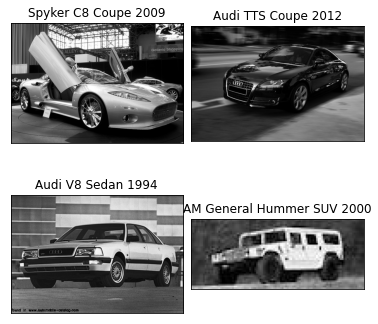

In [89]:
def plot_sample_data(im_files, a_labels, a_files, a_labs_1):
    """
    Plot few samples from image dataset

    Args:
        im_files: List holding image files
        a_labels: All original labels in the dataset
        a_files: All corresponding filenames in the dataset
        a_labs_1: Labels in text

    Returns:
        None

    Raises:
        None
    """

    fig, ax = plt.subplots(2,2, figsize=(7,6))
    for i in range(4):
        a = np.random.choice(range(len(im_files)))
        arr = cv2.imread(path + im_files[a]) #Convert image to array
        ax[i//2, i%2].imshow(arr) #Display image
        ax[i//2, i%2].get_xaxis().set_visible(False)
        ax[i//2, i%2].get_yaxis().set_visible(False)
        
        alab = a_labels[np.argwhere(a_files == ('car_ims/'+ im_files[a]))[0][0]]
        ax[i//2, i%2].set_title(a_labs_1['class_names'][0][alab-1][0])
        
    plt.subplots_adjust(left=0.1,
    bottom=0.1,
    right=0.8,
    top=0.8,
    wspace=0.05,
    hspace=0.3) #Adjust image

#This only plots when os.remove above is commented out. Otherwise, it gives an error
plot_sample_data(r_img_files, all_labels, all_files, all_labs_1)

## TASK 3

Next, an empty dictionary is created which maps indices of instances in the dataset to a dictionary with the structure described in the document. The goal here is to keep a record of the dataset instances. $N$ has been chosen to tbe the total number of images instances available after deleting images which are not RGB.

In [14]:
from torchvision import transforms
import torchvision

def get_dict(tr_ts, t_img_files, nlabels, nfiles, 
             path = 'images/car_ims/'):
    """
    Creates dictionary representation of embeddings

    Args:
        tr_ts: a dictionary of dataset indices and whether it is labelled or not
        t_img_files: a file of all images in the database
        labels: original information about labels in the dataset
        files: original information about images in dataset
        path: path to image files

    Returns:
        A dictionary containing embeddings, class index, 
        and labels for each dataset instance

    Raises:
        None
    """
       
    emb_dict = {}
    x_dict = {}
    files_ims = t_img_files
    
    nSHAPE = 512
    nCROP = 400
    
    # To stay consistent with the kind of images fed into the 
    # original resnet18, we need to apply these transformations
    manual_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((nSHAPE, nSHAPE)),
        transforms.CenterCrop(nCROP),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]) 
    ])

    #for j in range(len(x_tr_idx['idx'])):
    for i, j in enumerate(tr_ts['idx']):
        img_file = files_ims[j]
        img = cv2.imread(path + img_file)
        #img = cv2.resize(img, (nSHAPE, nSHAPE))
        img = manual_transforms(img).numpy()
        
        lab = nlabels[np.argwhere(nfiles == ('car_ims/'+ img_file))[0][0]]
        emb_dict['embedding'] = img
        emb_dict['class_idx'] = lab
        emb_dict['labelled'] = tr_ts['labelled']
        emb_dict['filename'] = img_file
        x_dict[i] = emb_dict
        emb_dict = {}
        
    return x_dict

Using PyTorch, a pre-trained restnet18 model is loaded. It's final layer is set to an identity layer so that the forward pass will return the output from the final average pooling layer. We ue this to get embeddings of size 512.

In [15]:
import torch.nn as nn
import torch
import torchvision.models as models

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def embed_feature(x):
    """
    Create embeddings using resnet18

    Args:
        x: Image vector

    Returns:
        Embedding which is size (x.shape[0], 512)

    Raises:
        None
    """
    model = models.resnet18(pretrained=True)
    model.fc = nn.Identity() #Alternative is to use Identity(). Here nn.Identity() is used. Both give same result
    output = model(x)
    #print(output.shape)
    return output

We create another function called `preprocess` to conduct the preprocessing needed for to carry out the transformation. The central idea here is to do this in batches instead of iterating one by one over the images. This saves time and computation resources. The dictionary is also shuffled prior to conducting the forward pass.

In [110]:
import copy

def preprocess(input_dict, BATCH_SIZE=20):
    """
    Conduct preprocessing on embeddings in input dictionary. 
    Input dictionary is shuffled prior to conducting forward pass.

    Args:
        input_dict: Input dictionary containing embeddings

    Returns:
        Output dictionary with embeddings changed to a vector of size 512

    Raises:
        None
    """
    
    g_dict = {}
    for n, m in input_dict.items():
        g_dict[n] = m['embedding']
    
    np.random.seed(2002)
    g_dict_ordered = list(g_dict.items())
    random.shuffle(g_dict_ordered)
    g_dict_ordered_zipped = list(zip(*g_dict_ordered))
    ndata = np.array(list(g_dict_ordered_zipped[1]))
#     ndata.shape
    
#     g_dict_ordered = list(zip(*sorted(g_dict.items(), key=lambda x: x[0])))
#     ndata = np.array(list(g_dict_ordered[1]))
#     n_ndata = (ndata / np.max(ndata, axis=(1,2,3), keepdims=True))
    
    mdata = []
    #BATCH_SIZE = 200
    for i in range(0, ndata.shape[0], BATCH_SIZE):
        print(f"Completed...{i}", end='\r')
        f = embed_feature(torch.tensor(ndata[i:(i+BATCH_SIZE)]).float())
        mdata.append(f.detach().numpy())
    nmdata = np.concatenate(mdata)
    m_dict = dict(zip(g_dict_ordered_zipped[0], nmdata))
    
    xx_dict = copy.deepcopy(input_dict)
    for i, j in m_dict.items():
        xx_dict[i]['embedding'] = j
    return xx_dict

In the following cells, we obtain all the images, iterate through them in batches and obtain the new embeddings of size 512.

In [87]:
# Obtain all files from database
files, labels = [], []
cfiles = [('car_ims/' + i) for i in n_img_files]
for i in all_labs_1['annotations'][0]:
    if i[0][0] in cfiles:
        files.append( i[0] )
        labels.append( i[-2] )
files =  np.array(files).ravel()
labels = np.array(labels).ravel()

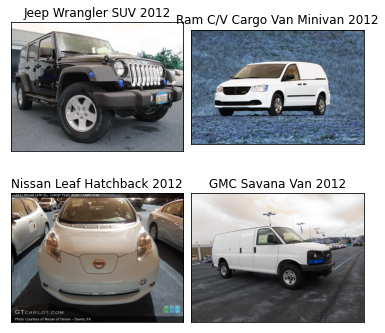

In [90]:
#Plot some sample data from database
plot_sample_data(n_img_files, all_labels, all_files, all_labs_1)

Next, we obtain the labelled and unlabelled instances using the function earlier creates in TASK 1

## TASK 4

In [38]:
adata, alabels = [], []
for _, y in zip(files, labels):
    alabels.append(y)
x_tr_idx, x_ts_idx, y_tr_idx, y_ts_idx = convert_labels(alabels)

In [39]:
print(x_tr_idx['idx'].shape)
print(x_ts_idx['idx'].shape)
print(y_tr_idx.shape)
print(y_ts_idx.shape)

(6463,)
(9688,)
(6463,)
(9688,)


We find that this allots only 40\% of the data to the labelled set and 60\% to the unlabelled set, i.e. $0.4 \times 16185 \approx 6460$ is assigned to the labelled set in `x_tr_idx`. We can take a pick at a few elements from this variable

In [41]:
x_tr_idx

{'idx': array([   22,    23,    55, ..., 16135, 16113, 16130]), 'labelled': 1}

Now we create the embedding dictionary

In [42]:
i_dict = get_dict(x_tr_idx, n_img_files,
                         labels, files)
h_dict = get_dict(x_ts_idx, n_img_files,
                         labels, files)

In [43]:
n_idx = max(list(i_dict.keys())) + 1
nh_dict = {k+n_idx: v for k,v in h_dict.items()}
f_dict = {**i_dict, **nh_dict}

Having created the embedding dictionary, we can take a look at a few samples in it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


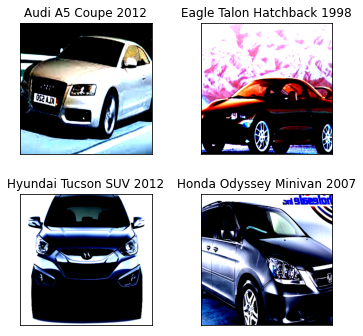

In [104]:
r_sample = np.random.choice(list(f_dict.keys()),4)
fig, ax = plt.subplots(2,2, figsize=(7,6))

for i,j  in enumerate(r_sample):
    arr = f_dict[j]['embedding'].T
    arr = cv2.rotate(arr, cv2.ROTATE_90_CLOCKWISE)
    ax[i//2, i%2].imshow(arr)
    ax[i//2, i%2].get_xaxis().set_visible(False)
    ax[i//2, i%2].get_yaxis().set_visible(False)
    
    alab = all_labels[np.argwhere(all_files == ('car_ims/'+ f_dict[j]['filename']))[0][0]]
    ax[i//2, i%2].set_title(all_labs_1['class_names'][0][alab-1][0])

plt.subplots_adjust(left=0.1,
bottom=0.1,
right=0.8,
top=0.8,
wspace=0.05,
hspace=0.3)


Next, we preprocess this dictionary to transform the embeddings using the function `preprocess`

In [111]:
e_dict = preprocess(f_dict, BATCH_SIZE=200)

In [112]:
# Save embedding dictionary
torch.save(e_dict, 'input_data.pth')

## TASK 5

We use sci-kit learn to create a train/validation split, i.e. split the labelled data into training and validation by the training proportion.

In [113]:
# Load saved embeddings
embed_aap = torch.load('input_data.pth')

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [115]:
def create_data_labels(dataset_inputs, dataset_labels, training_proportion=0.4):
    """
    Split arrays or matrices into random train and test subsets.
    Wrapper for sklearn's train_test_split.

    Args:
        dataset_inputs: input dataset of form m x n
        dataset_labels: input labels of form m
        training_proportion: proportion of training data in split

    Returns:
        Tuple of training split, training labels, validation split, validation labels

    Raises:
        None
    """
    X_train, X_test, y_train, y_test = \
    train_test_split(dataset_inputs, dataset_labels, 
                     train_size=training_proportion, random_state=42) #Get train/validation split
    return X_train, y_train, X_test, y_test

## TASK 6

We create a dataframe from the embeddings dictionary. This makes it easy to filter along values and extract necessary information

In [150]:
# Create a dataframe from embeddings dictionary
df_embed_aap_p = pd.DataFrame(embed_aap).T
print(df_embed_aap_p.shape)

(16151, 4)


In [151]:
df_embed_aap_p.head() #Show some instances of dataset

,embedding,class_idx,labelled,filename
0,"[1.0317923, 0.5202224, 0.26126018, 0.94456744,...",1,1,000023.jpg
1,"[0.38107276, 0.45380488, 0.5565311, 0.4093619,...",1,1,000024.jpg
2,"[0.87973845, 1.0919739, 0.9927466, 2.130259, 2...",1,1,000057.jpg
3,"[0.56745136, 0.81432927, 1.0400885, 0.60181916...",1,1,000061.jpg
4,"[1.2908789, 0.59407496, 0.9400605, 2.1067889, ...",1,1,000039.jpg


Next, we carry out an experiment to convince clients that more labelled data will improve model performance. This experiment is set up by increasing the training proportion gradually from 0.1 to 0.9 and iterating through the resulting values. For each iteration, we train on the training set and obtain a validation loss using the validation set. Our hypothesis is that, as the training proportion increases the accuracy of whatever model we create should also increase.

In setting up this experiment, we ensure that every instance is represented in both the training and validation sets, i.e every dataset instance has a label in both. As instruced, `SGDClassifier` is used and no attempts are made at tuning hyperparameters.

In [152]:
import time

l_aap_p = df_embed_aap_p[df_embed_aap_p['labelled'] == 1] #Obtain labelled set
print( l_aap_p.shape ) #Show it is only 40% of total data, i.e. 40*16151=6460

(6463, 4)


In [153]:
X = np.array(l_aap_p['embedding'].to_list())
y = np.array(l_aap_p['class_idx'])

np.random.seed(2002) #Set random seed for reproducibility

#Shuffle dataset to introduce randomness
arr = np.arange(X.shape[0])
np.random.shuffle(arr)
X = X[arr]
y = y[arr]


props = np.linspace(0.2,0.90,20)
aprops, yy_ = [], []

for prop in props:
    start_time = time.perf_counter()
    
    sgd_x_train, sgd_y_train, sgd_x_val, sgd_y_val = create_data_labels(X, y, training_proportion=prop)
    sgd_y_train = sgd_y_train.astype(int)
    sgd_y_val = sgd_y_val.astype(int)
    
    a = np.unique(sgd_y_train, return_counts=True)
    b = np.unique(sgd_y_val, return_counts=True)
    if len(a[1]) != len(b[1]):
        print(f"Skipped training proportion...{round(prop,3)}.", end= " ")
        continue
    else:
        
        print(f"Completing training proportion...{round(prop,3)}.", end = " ")

        SGDClassifier(max_iter=200, penalty='l1', alpha=1e-5)
        clf_1.fit(sgd_x_train, sgd_y_train)
        y_pred = clf_1.predict(sgd_x_val)
        yy_.append(1 - np.mean(y_pred == sgd_y_val))
        #print(yy_)
        aprops.append(prop)
    end_time = time.perf_counter()
    #print("\n")
    print(f"Took {round(end_time-start_time,5)} seconds")
     

Completing training proportion...0.2. Took 6.95685 seconds
Completing training proportion...0.237. Took 8.68233 seconds
Completing training proportion...0.274. Took 10.50814 seconds
Completing training proportion...0.311. Took 12.23765 seconds
Completing training proportion...0.347. Took 14.10672 seconds
Completing training proportion...0.384. Took 16.03713 seconds
Completing training proportion...0.421. Took 18.47002 seconds
Completing training proportion...0.458. Took 20.37745 seconds
Completing training proportion...0.495. Took 22.75494 seconds
Completing training proportion...0.532. Took 25.36445 seconds
Completing training proportion...0.568. Took 27.64384 seconds
Completing training proportion...0.605. Took 29.62422 seconds
Completing training proportion...0.642. Took 33.39077 seconds
Completing training proportion...0.679. Took 36.3032 seconds
Completing training proportion...0.716. Took 39.90378 seconds
Completing training proportion...0.753. Took 42.37043 seconds
Completing tr

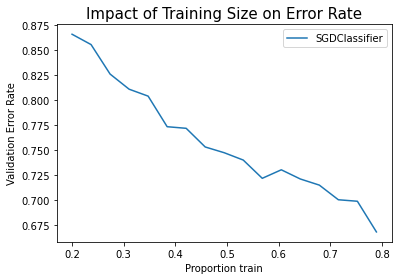

In [154]:
plt.plot(aprops, yy_, label='SGDClassifier')
plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Validation Error Rate")
plt.title("Impact of Training Size on Error Rate", fontsize=15)
plt.show()

We find that as the training proportion increases, the validation error rate reduces. This shows confirms our hypothesis that if we are able to train on more information, we may be able to reduce the validation loss. This is particularly important in machine learning where, not just the volume of data, but also its quality matter greatly in achieving excellent model results.

We show a sample plot here from the last split showing that there is at least one class instance present in both training and validation

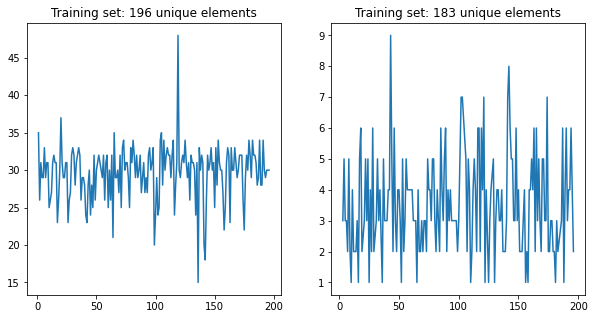

In [156]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
a = np.unique(sgd_y_train, return_counts=True)
plt.plot(a[0], a[1])
plt.title(f"Training set: {len(a[1])} unique elements")

plt.subplot(1,2,2)
b = np.unique(sgd_y_val, return_counts=True)
plt.plot(b[0], b[1])
plt.title(f"Training set: {len(b[1])} unique elements")
plt.show()

## TASK 7

Now, the clients have agreed to label an additional 25\% of the dataset to bring the total training set to 65\%. Firstly, we use the model trained on 40\% of the data on the unlabelled input. We then obtain the predicted probabilities for each class in the unlabelled instances. We then use the entropy function in `scipy.stats` to compute the entropy of the predictions of the unlabelled instances.

We train first on 40\% of the dataset instances which are labelled.

In [157]:
from scipy.stats import entropy

# Train model on 40% of the data
#GDClassifier(max_iter=200, penalty='l1', alpha=1e-5)
clf_2 = SGDClassifier(loss="modified_huber", max_iter=100, penalty='l1', alpha=1e-5)
y = y.astype(int)
clf_2.fit(X, y)
y_pred = clf_2.predict(X)
print(f"Training loss: {1 - np.mean(y_pred == y)}")

Training loss: 0.0021661766981277975


We obtain a very low loss training loss here. Next, we predict on the remainder 60\% of the data

In [158]:
# Predict on the remainder 60% unlabelled set
ul_aap_p = df_embed_aap_p[df_embed_aap_p['labelled'] == 0]
print ( ul_aap_p.shape ) # Show that 60% of the dataset is unlabelled, i.e. 60*16151=9690

(9688, 4)


In [159]:
uX = np.array(ul_aap_p['embedding'].to_list())
uy = np.array(ul_aap_p['class_idx'])
uy.shape, uX.shape

arr = np.arange(uX.shape[0])
np.random.shuffle(arr)
uX = uX[arr]
uy = uy[arr]
uy = uy.astype(int)

# Predict on unlabelled dataset
uy_pred = clf_2.predict(uX)
print(f"Testing loss: {1 - np.mean(uy_pred == uy)}")

proba = clf_2.predict_proba(uX)
eproba = entropy(proba.T)


Testing loss: 0.6309867877786952


Testing loss is also quite low. 

We find that we would need to add an additional 4035 to the labelled set to arrive at 65\%.

In [160]:
int(0.65 * (l_aap_p.shape[0] + ul_aap_p.shape[0])) - l_aap_p.shape[0] 
# We have 4035 datasets to add

4035

In the plot below, we show that all the 4035 selected have significantly high entropy values. We use `np.argsort` to select the highest $K$ values.

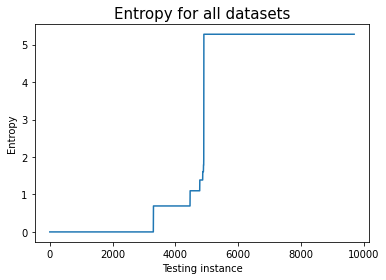

In [161]:
plt.plot(eproba[np.argsort(eproba)])
plt.title("Entropy for all datasets", fontsize=15)
plt.xlabel("Testing instance")
plt.ylabel("Entropy")
plt.show()

In [162]:
t_inc = np.argsort(eproba)[-4035:] #indices of additional labelled instance
m_inc = np.argsort(eproba)[:-4035] #indices of new unlabelled instances


In [163]:
ml_aap_p = ul_aap_p.iloc[t_inc].copy()
ml_aap_p.loc[:, 'labelled'] = 1
ml_aap_p


fl_aap_p = pd.concat([l_aap_p, ml_aap_p], axis=0)
print(fl_aap_p.shape) #new labelled set

nl_aap_p = ul_aap_p.iloc[m_inc].copy()
print(nl_aap_p.shape) # new unlabelled set

(10498, 4)
(5653, 4)


Using the new shapes, we find that we now have $0.65 \times 16151 \approx 10498$ new labelled instances, while the remainder are unlabelled. Both add up to 16151 instances which is the total size of the database.

## TASK 8

Finally, using the training dataset, we train a final model and use it to evaluate the model on the hold-out validation dataset.

In [138]:
fX = np.array(fl_aap_p['embedding'].to_list())
fy = np.array(fl_aap_p['class_idx'])
fy.shape, fX.shape

nX = np.array(nl_aap_p['embedding'].to_list())
ny = np.array(nl_aap_p['class_idx'])
ny.shape, nX.shape

arr = np.arange(fX.shape[0])
np.random.shuffle(arr)
fX = fX[arr]
fy = fy[arr]
fy = fy.astype(int)

arr = np.arange(nX.shape[0])
np.random.shuffle(arr)
nX = nX[arr]
ny = ny[arr]
ny = ny.astype(int)

In [144]:

# Train model on 40% of the data
clf_3 = SGDClassifier(max_iter=200, penalty='l1', alpha=1e-5)
fy = fy.astype(int)
clf_3.fit(fX, fy)
fy_pred = clf_3.predict(fX)
print(f"Training loss: {1 - np.mean(fy_pred == fy)}")


# Predict on unlabelled dataset
ny_pred = clf_3.predict(nX)
print(f"Testing loss: {1 - np.mean(ny_pred == ny)}")

Training loss: 0.006477424271289722
Testing loss: 0.5996815849991155


Finally, we obtain a lower value of validation (or testing) with more training instances used in training the SGD model, though this isn't significantly lower. It is about ~6% lower than earlier. However, following the characteristic of the earlier plot, we can expect that alloting more datasets to the labelled instances should further improve performance of the model and improve the validation (or testing) loss. In addition, conducting some hyperparameter tuning may have helped with improving the losses obtained for all classifiers.

We posit that the decision to label more instances is a good one.

## Conclusions & Recommendations

We achieve the overall aim of establishing that labelling more data can help improve model quality. This simply affords better training for the model, since it has access to more information for improving its decision-making. In conclusion, as we increase the training proportion, we obtain better loss metrics on the hold-out instances.

There are however other ways we could improve our model. Some of these include:
1. allowing hyperparameter tuning, even though this could take significantly more time
2. introducing image augmentation into the pipeline, as the training loss appears to show some overfitting.
3. Increasing the size of our dataset by adding more instances. This increases the number of training instances proportionally and could effectively help with model quality
4. try other kinds of classifiers, especially non-linear types. `SGDClassifier` is a linear classifier which may not be able to learn some of the non-linearities in the dataset.
5. try other predefined models which are superior to `Resnet18` for the feature extraction stage.
6. alternatively just use other deep learning classifiers to complete the classification task, instead of using `SGDClassifier`.